In [ ]:
'''
II   Approximate Solution Methods

1, 

'''

In [7]:
'''
2, Episodic Semi-gradient Sarsa for Estimating q_hat ≈ q*   ---P244 Reinforcement Learning Richard S. Sutton and Andrew G. Barto
'''

import gym
import numpy as np
env_name = "MountainCar-v0"
env = gym.make(env_name)

# This is just an implementation of the classic “agent-environment loop”. 
# Each timestep, the agent chooses an action, and the environment returns an observation and a reward.
# The process gets started by calling reset(), which returns an initial observation 

obs = env.reset() 
env.render()
n_states = 40
q_table=np.zeros((n_states,n_states,env.action_space.n))


N = n_states*n_states*env.action_space.n
X,y=[],[]
for i in range(n_states):
    for j in range(n_states):
        for k in range(env.action_space.n):
            X.append([i,j,k])
            y.append(q_table[i][j][k])

X = np.matrix(X)
y = np.matrix(y).T
print(X.shape,y.shape)


# J = 20basis functions obtained by k-means clustering
# sigma set to standard deviation of entire data
from sklearn.cluster import KMeans
J = 6;
kmeans = KMeans(n_clusters=J,random_state=0).fit(X)
sig=np.std(X)

#Construct design matrix
U=np.zeros((N,J))
for i in range(N):
    for j in range(J):
        U[i][j]=np.exp(-(np.linalg.norm(X[i]-kmeans.cluster_centers_[j]) / sig)**2)
        

#Solve RBF model, predict and plot
# w=np.dot((np.linalg.inv(np.dot(U.T,U))), U.T) * y
# yh_rbf = np.dot(U,w)

(4800, 3) (4800, 1)


In [8]:
def q_hat(pos,vel,a,w):
    # https://stackoverflow.com/questions/18927475/numpy-array-get-row-index-searching-by-a-row
    idx=np.where(np.all(X==[pos,vel,a],axis=1))
    return np.dot(np.squeeze(U[idx[0]]),w),idx[0]

# idx=np.where(np.all(X==[39,39,2],axis=1))
# print(idx[0])
# print(np.squeeze(U[idx[0]]))

# print([q_hat(1,1,0,w)[0]-1,q_hat(1,1,0,w)[0],q_hat(1,1,0,w)[0]-2])
# print(np.argmax([q_hat(1,1,0,w)[0]-1,q_hat(1,1,0,w)[0],q_hat(1,1,0,w)[0]-2]))

In [9]:
# Some initializations
#
episodes = 4
gamma = 0.98
epsilon = 0.05
env = env.unwrapped # https://stackoverflow.com/questions/53836136/why-unwrap-an-openai-gym 
# env.seed()
# np.random.seed(0)

# Quantize the states
#
def discretization(env, obs):
    env_low = env.observation_space.low # the lower bound of position: -1.2,and velocity:-0.07
    env_high = env.observation_space.high # the upper bound of position: 0.6,and velocity:0.07
    env_den = (env_high - env_low)/n_states # the density of one state=[0.045, 0.0035]=[0.6-(-1.2), 0.07-(-0.07)]/40(# of states)
    pos_den = env_den[0]
    vel_den = env_den[1]
    
    pos_high = env_high[0]
    pos_low=env_low[0]
    vel_high=env_high[1]
    vel_low=env_low[1]
    
    pos_scaled=int((obs[0]-pos_low)/pos_den) # discretize the postion value as int in the state space
    vel_scaled=int((obs[1]-vel_low)/vel_den) # discretize the velocity value as int in the state space 
    return pos_scaled,vel_scaled


alpha=0.05
w = np.random.randn(J,1)
error=[]

for episode in range(episodes):
    print("Episode:",episode)
    
    obs=env.reset() # initialize state S
    pos, vel = discretization(env, obs) # discretize the current state
    if np.random.uniform(low=0, high=1) < epsilon:# Ɛ-greedy method: select a random action 'a' with probability Ɛ to initialize state A
        a = np.random.choice(env.action_space.n) 
    else:
        a = np.argmax([q_hat(pos,vel,0,w)[0],q_hat(pos,vel,1,w)[0],q_hat(pos,vel,2,w)[0]])
    
    while True:
        env.render()
        pos, vel = discretization(env, obs) # discretize the current state
        obs, reward, terminate,_ = env.step(a)  #Take action A, observe R, S'
        print(w)
        print(obs, reward,a, terminate)
        delta_qhat=np.array(U[q_hat(pos,vel,a,w)[1],:]).T
        if terminate:
            w=w+alpha*(reward-q_hat(pos,vel,a,w)[0])*delta_qhat # Updtae w if the episode is terminated
            error.append((reward-q_hat(pos,vel,a,w)[0])**2)
            break #Go to the next episode
        #Choose A' as a function of q_hat(S', ·, w) (e.g., Ɛ-greedy)
        pos_, vel_ = discretization(env, obs) #discretize the next state
        if np.random.uniform(low=0, high=1) < epsilon:# Ɛ-greedy method: select a random action 'a' with probability Ɛ
            a_ = np.random.choice(env.action_space.n) 
        else:
            a_ = np.argmax([q_hat(pos_,vel_,0,w)[0],q_hat(pos_,vel_,1,w)[0],q_hat(pos_,vel_,2,w)[0]])
        w=w+alpha*(reward+gamma*q_hat(pos_,vel_,a_,w)[0]-q_hat(pos,vel,a,w)[0])*delta_qhat #Update w if the episode is not terminated
        error.append((reward+gamma*q_hat(pos_,vel_,a_,w)[0]-q_hat(pos,vel,a,w)[0])**2)
        a=a_ #Reassign a
'''            
            
while True:
    env.render()
    '''

Episode: 0
[[ 1.7639379 ]
 [ 0.22734384]
 [-0.1306001 ]
 [ 0.29876936]
 [ 0.9016107 ]
 [ 0.87070964]]
[-0.43931591 -0.00062998] -1.0 1 False
[[ 1.7365597 ]
 [ 0.22181453]
 [-0.13680586]
 [ 0.28613102]
 [ 0.88675635]
 [ 0.82651199]]
[-0.4405713  -0.00125539] -1.0 1 False
[[ 1.70921341]
 [ 0.21629167]
 [-0.14300438]
 [ 0.2735074 ]
 [ 0.87191931]
 [ 0.78236586]]
[-0.44244297 -0.00187168] -1.0 1 False
[[ 1.681899  ]
 [ 0.21077525]
 [-0.14919568]
 [ 0.26089851]
 [ 0.85709955]
 [ 0.73827118]]
[-0.44491732 -0.00247435] -1.0 1 False
[[ 1.65461642]
 [ 0.20526525]
 [-0.15537976]
 [ 0.24830431]
 [ 0.84229708]
 [ 0.6942279 ]]
[-0.44797632 -0.00305899] -1.0 1 False
[[ 1.62736565]
 [ 0.19976168]
 [-0.16155663]
 [ 0.23572478]
 [ 0.82751185]
 [ 0.65023595]]
[-0.45159763 -0.00362131] -1.0 1 False
[[ 1.60032321]
 [ 0.19430018]
 [-0.16768628]
 [ 0.22324144]
 [ 0.81283967]
 [ 0.60658034]]
[-0.45575476 -0.00415713] -1.0 1 False
[[ 1.57353346]
 [ 0.18956015]
 [-0.17465896]
 [ 0.212745  ]
 [ 0.79563332]
 [ 0

KeyboardInterrupt: 

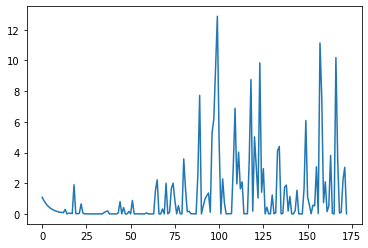

In [12]:
import matplotlib.pyplot as plt
plt.plot(error[::100])

In [11]:
len(error)

17212